Shape: (200, 43)
Columns: ['Age of the patient', 'Blood pressure (mm/Hg)', 'Specific gravity of urine', 'Albumin in urine', 'Sugar in urine', 'Red blood cells in urine', 'Pus cells in urine', 'Pus cell clumps in urine', 'Bacteria in urine', 'Random blood glucose level (mg/dl)', 'Blood urea (mg/dl)', 'Serum creatinine (mg/dl)', 'Sodium level (mEq/L)', 'Potassium level (mEq/L)', 'Hemoglobin level (gms)', 'Packed cell volume (%)', 'White blood cell count (cells/cumm)', 'Red blood cell count (millions/cumm)', 'Hypertension (yes/no)', 'Diabetes mellitus (yes/no)', 'Coronary artery disease (yes/no)', 'Appetite (good/poor)', 'Pedal edema (yes/no)', 'Anemia (yes/no)', 'Estimated Glomerular Filtration Rate (eGFR)', 'Urine protein-to-creatinine ratio', 'Urine output (ml/day)', 'Serum albumin level', 'Cholesterol level', 'Parathyroid hormone (PTH) level', 'Serum calcium level', 'Serum phosphate level', 'Family history of chronic kidney disease', 'Smoking status', 'Body Mass Index (BMI)', 'Physica

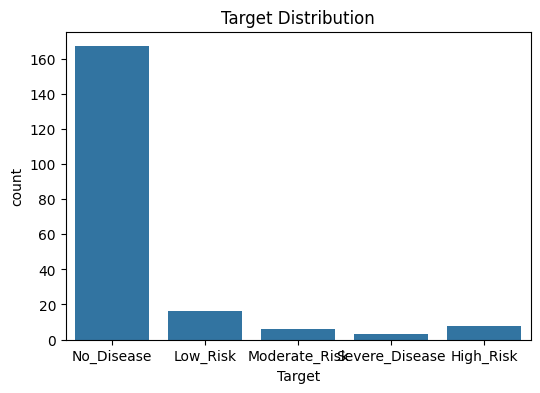

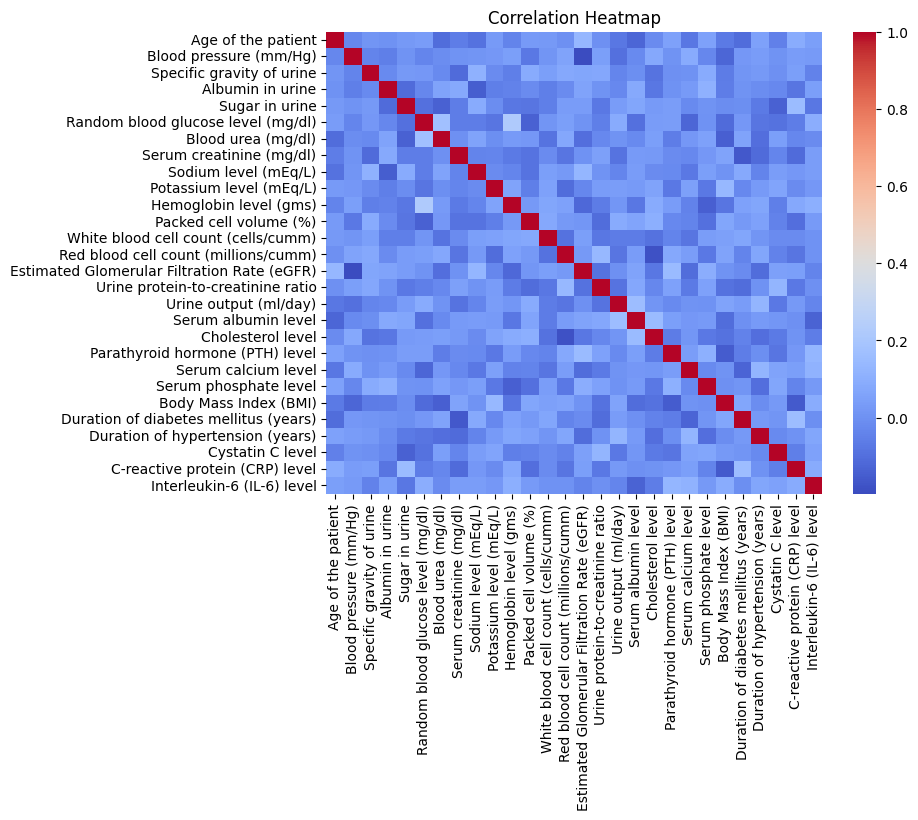


ML Results:
                  Model  Accuracy  Precision  Recall        F1   ROC-AUC
0  Logistic Regression     0.750   0.707143   0.750  0.727941  0.602960
1        Decision Tree     0.625   0.644531   0.625  0.634615  0.394007
2        Random Forest     0.825   0.680625   0.825  0.745890  0.580027
3                  SVM     0.825   0.680625   0.825  0.745890  0.583814
4                  KNN     0.825   0.680625   0.825  0.745890  0.602000
5    Gradient Boosting     0.750   0.668919   0.750  0.707143  0.503304


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



MLP Accuracy: 0.824999988079071


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


CNN Accuracy: 0.824999988079071
LSTM Accuracy: 0.824999988079071
Hybrid CNN+LSTM Accuracy: 0.824999988079071
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Autoencoder+Classifier Accuracy: 0.824999988079071


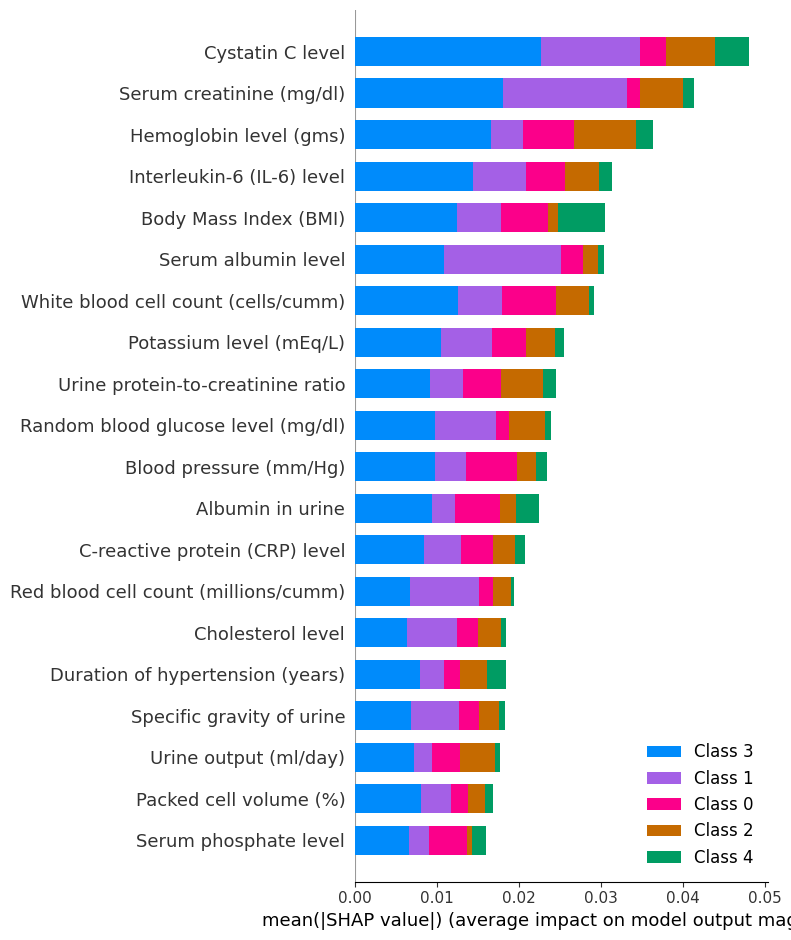

In [4]:
# ===============================
# LAB ASSIGNMENT 6 - Kidney Disease Prediction
# ===============================

!pip install shap lime --quiet

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# DL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, MaxPooling1D

# XAI
import shap
import lime
import lime.lime_tabular

# ===============================
# Load dataset (first 200 rows for fast run)
# ===============================
df = pd.read_csv("/content/drive/MyDrive/aiml projects/kidney_disease_dataset.csv", nrows=200)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# ===============================
# EDA
# ===============================
print("\nMissing values:\n", df.isnull().sum().head())
print("\nClass distribution:\n", df['Target'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x="Target", data=df)
plt.title("Target Distribution")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# ===============================
# Preprocessing
# ===============================
# Encode categorical
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Fill missing values
for col in df.columns:
    if df[col].dtype in ['float64','int64']:
        df[col] = df[col].fillna(df[col].mean())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])

X = df.drop(columns=['Target'])
y = df['Target']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

num_classes = len(y.unique())

# ===============================
# Machine Learning Models
# ===============================
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    rec = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    # ROC-AUC (safe for multi-class)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
        y_test_bin = pd.get_dummies(y_test)
        y_prob_aligned = pd.DataFrame(y_prob, columns=model.classes_)
        y_prob_aligned = y_prob_aligned.reindex(columns=y_test_bin.columns, fill_value=0)
        auc = roc_auc_score(y_test_bin, y_prob_aligned, average="weighted", multi_class="ovr")
    else:
        auc = np.nan

    results.append([name, acc, prec, rec, f1, auc])

results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1","ROC-AUC"])
print("\nML Results:\n", results_df)

# ===============================
# Deep Learning Models
# ===============================

# ----- 1. MLP -----
mlp = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp.fit(X_train, y_train, epochs=5, batch_size=16, verbose=0)
mlp_eval = mlp.evaluate(X_test, y_test, verbose=0)
print("\nMLP Accuracy:", mlp_eval[1])

# ----- 2. CNN (1D) -----
cnn = Sequential([
    tf.keras.layers.Reshape((X_train.shape[1],1), input_shape=(X_train.shape[1],)),
    Conv1D(32, 3, activation='relu'),
    Conv1D(64, 3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_train, y_train, epochs=5, batch_size=16, verbose=0)
cnn_eval = cnn.evaluate(X_test, y_test, verbose=0)
print("CNN Accuracy:", cnn_eval[1])

# ----- 3. LSTM -----
lstm = Sequential([
    tf.keras.layers.Reshape((X_train.shape[1],1), input_shape=(X_train.shape[1],)),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm.fit(X_train, y_train, epochs=5, batch_size=16, verbose=0)
lstm_eval = lstm.evaluate(X_test, y_test, verbose=0)
print("LSTM Accuracy:", lstm_eval[1])

# ----- 4. Hybrid CNN + LSTM -----
hybrid = Sequential([
    tf.keras.layers.Reshape((X_train.shape[1],1), input_shape=(X_train.shape[1],)),
    Conv1D(32, 3, activation='relu'),
    MaxPooling1D(2),
    LSTM(32),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])
hybrid.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
hybrid.fit(X_train, y_train, epochs=5, batch_size=16, verbose=0)
hybrid_eval = hybrid.evaluate(X_test, y_test, verbose=0)
print("Hybrid CNN+LSTM Accuracy:", hybrid_eval[1])

# ----- 5. Autoencoder + Classifier -----
encoding_dim = 16
input_dim = X_train.shape[1]

# Encoder
encoder = Sequential([
    Dense(32, activation='relu', input_shape=(input_dim,)),
    Dense(encoding_dim, activation='relu')
])

# Decoder
decoder = Sequential([
    Dense(32, activation='relu', input_shape=(encoding_dim,)),
    Dense(input_dim, activation='linear')
])

# Autoencoder
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=5, batch_size=16, verbose=0)

# Encoded features
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Classifier
auto_clf = Sequential([
    Dense(32, activation='relu', input_shape=(encoding_dim,)),
    Dense(num_classes, activation='softmax')
])
auto_clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
auto_clf.fit(X_train_encoded, y_train, epochs=5, batch_size=16, verbose=0)
auto_eval = auto_clf.evaluate(X_test_encoded, y_test, verbose=0)
print("Autoencoder+Classifier Accuracy:", auto_eval[1])

# ===============================
# XAI
# ===============================
explainer = shap.Explainer(models["Random Forest"], X_train)
shap_values = explainer(X_test[:50])
shap.summary_plot(shap_values, X_test[:50], feature_names=df.drop(columns=['Target']).columns)

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train,
    feature_names=df.drop(columns=['Target']).columns,
    class_names=list(map(str,y.unique())),
    discretize_continuous=True
)
exp = lime_explainer.explain_instance(X_test[0], models["Random Forest"].predict_proba, num_features=5)
exp.show_in_notebook(show_table=True)
